In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import cmath
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cbook, cm
from matplotlib.colors import LightSource
import scipy.stats as stats
from scipy.optimize import minimize
from scipy.interpolate import splev, splrep
import yfinance as yf

In [3]:
def acquire_stock_price(ticker_name_index, trade_date_index):
    ticker_list = ['AZN.L', 'BATS.L', 'BHP.L', 'DGE.L', 'HSBA.L', 'RIO.L', 'RKT.L', 'SHEL.L', 'ULVR.L', 'VOD.L']
    ticker_name = ticker_list[ticker_name_index]
    trade_date_list = ['2024-01-17', '2024-02-16', '2024-03-15', '2024-04-17']
    trade_date_later = ['2024-01-18', '2024-02-17', '2024-03-16', '2024-04-18']
    trade_date = trade_date_list[trade_date_index]
    next_trade_date = trade_date_later[trade_date_index]
    ticker = yf.Ticker(ticker_name)
    ticker_historical_price = ticker.history(start=trade_date, end=next_trade_date, interval='1d')
    return ticker_historical_price['Open'].tolist()[0]


def acquire_option_price(ticker_name_index, trade_date_index):
    ticker_list_no_l = ['AZN', 'BATS', 'BHP', 'DGE', 'HSBA', 'RIO', 'RKT', 'SHEL', 'ULVR', 'VOD']
    ticker_name = ticker_list_no_l[ticker_name_index]
    csv_file_name = ticker_name + ' portfolio construction sheet.csv'
    csv_file = pd.read_csv(csv_file_name)
    return csv_file.iloc[trade_date_index + 4, 5]


def acquire_option_middle_strike(ticker_name_index, trade_date_index):
    ticker_list_no_l = ['AZN', 'BATS', 'BHP', 'DGE', 'HSBA', 'RIO', 'RKT', 'SHEL', 'ULVR', 'VOD']
    ticker_name = ticker_list_no_l[ticker_name_index]
    csv_file_name = ticker_name + ' portfolio construction sheet.csv'
    csv_file = pd.read_csv(csv_file_name)
    return csv_file.iloc[trade_date_index + 4, 6]


In [4]:
#risk free rate on Jan. 2024
r = 0.0529
#Dividend yield
q = 0

N = 2 ** 10
delta_v = 0.4
delta_k = 2 * np.pi / N / delta_v
alpha = 0.8

In [5]:
def calc_lambda(u, sigma, rho, kappa):
    return (sigma ** 2 * (u ** 2 + u * 1j) + (kappa - rho * sigma * u * 1j) ** 2) ** 0.5

def calc_omega(u, lamb, sigma, rho, kappa, theta, t, r, q, s0):
    numerator = np.exp(np.log(s0) * u * 1j + u * t * (r - q) * 1j + kappa * theta * t * (kappa - rho * sigma * u * 1j) / sigma ** 2)
    #lamb = calc_lambda(sigma, u, kappa, rho)
    denominator = (np.cosh(lamb * t / 2) + (kappa - rho * sigma * u * 1j) * np.sinh(lamb * t / 2) / lamb) ** (2 * kappa * theta / sigma ** 2)
    return numerator / denominator

def calc_phi(u, sigma, rho, kappa, theta, t, r, q, s0, v0):
    lamb = calc_lambda(u, sigma, rho, kappa)
    #print(lamb)
    omega = calc_omega(u, lamb, sigma, rho, kappa, theta, t, r, q, s0)
    #print(t)
    #print(np.tanh(lamb * t / 2))
    return omega * np.exp(-v0 * (pow(u, 2) + u * 1j) / (lamb / np.tanh(lamb * t / 2) + kappa - rho * sigma * u * 1j))

def calc_ct_fft(alpha, N, delta_v, delta_k, k, sigma, rho, kappa, theta, t, r, q, s0, v0):
    delta = np.zeros(N)
    delta[0] = 1
    v_list = np.arange(N) * delta_v
    beta = np.log(s0) - delta_k * N / 2
    km = beta + np.arange(N) * delta_k
    
    x = np.zeros(N, dtype=complex)
    for j in range(N):
            u = v_list[j] - (alpha + 1) * 1j
            phi = calc_phi(complex(v_list[j], -alpha - 1), sigma, rho, kappa, theta, t, r, q, s0, v0)
            x_j = phi * np.exp(-1j * beta * v_list[j])
            x_j = x_j * (2 - delta[j]) * delta_v / (2 * (alpha + v_list[j] * 1j) * (alpha + 1 + v_list[j] * 1j))
            x[j] = x_j
    
    y_1 = np.array(np.fft.fft(x)).real
    y_2 = np.exp(- alpha * np.array(km)) / np.pi
    y = y_1 * y_2 * np.exp(-r * t)
    k_list = list(np.exp(km))
    y_list = list(y)

    tck = splrep(k_list, y_list)
    ct = splev(k, tck = tck).real
    
    return ct, [k_list, y_list]

In [6]:
def price_diff(params, alpha, N, delta_v, delta_k, r, q, s0, df):
    result = 0
    #iterate through each expiry/each T
    for i in df.index.get_level_values(0).unique():
        #print(i)
        #用中间的K做fft，然后interpolation算出其他K的价格
        K = df.loc[i].iloc[df.loc[i].shape[0]//2].name
        T = df.loc[i].iloc[df.loc[i].shape[0]//2]['T']
        model_c, inter_data= calc_ct_fft(alpha, N, delta_v, delta_k, K, params[0], params[1], params[2], params[3], T, r, q, s0, params[4])
        interpolation = splrep(inter_data[0], inter_data[1])
        #iterate through each strike at given expiry
        for j in df.loc[i].index:
            #print(j)
            #用interpolation算出model price
            model_price = splev(j, tck = interpolation)
            result += (model_price - df.loc[i,j]['Mid']) ** 2
        #print(model_price)
    #print(result)
    return result

In [7]:
fileNames =['AZN calibration sheet.csv',
            'BATS calibration sheet.csv',
            'BHP calibration sheet.csv',
            'DGE calibration sheet.csv',
            'HSBA calibration sheet.csv',
            'RIO calibration sheet.csv',
            'RKT calibration sheet.csv',
            'SHEL calibration sheet.csv',
            'ULVR calibration sheet.csv',
            'VOD calibration sheet.csv'
           ]
options = ['AZN', 'BATS', 'BHP', 'DGE', 'HSBA', 'RIO', 'RKT', 'SHEL', 'ULVR', 'VOD']

In [8]:
parameterTable = pd.DataFrame(index = options, columns =['kappa', 'theta', 'xi', 'rho', 'sigma0'])
#initial guess
parameterTable.loc['AZN'] = [0.2, -0.4, 0.7, 0.1, 0.08]
parameterTable.loc['BATS'] = [0.2, -0.4, 0.7, 0.1, 0.08]
parameterTable.loc['BHP'] = [0.5, -0.4, 1, 0.2, 0.1]
parameterTable.loc['DGE'] = [0.2, -0.4, 0.7, 0.1, 0.08]
parameterTable.loc['HSBA'] = [0.1, -0.7, 1, 0.1, 0.08]
parameterTable.loc['RIO'] = [0.2, -0.4, 0.7, 0.1, 0.08]
parameterTable.loc['RKT'] = [0.5, -0.1, 1, 0.5, 0.1]
parameterTable.loc['SHEL'] = [0.5, -0.4, 1, 0.2, 0.1]
parameterTable.loc['ULVR'] = [2, -0.5, 0.8, 0.2, 0.1]
parameterTable.loc['VOD'] = [0.2, -0.4, 0.7, 0.1, 0.08]

In [9]:
bounds = [
    tuple(zip([0.001, -1, 0.001, 0.001, 0.01], [5, 1, 10, 1, 1])),
    tuple(zip([0.001, -1, 0.001, 0.001, 0.01], [5, 1, 20, 1, 1])),
    tuple(zip([0.001, -1, 0.001, 0.001, 0.01], [10, 1, 50, 1, 1])),
    tuple(zip([0.001, -1, 0.001, 0.001, 0.01], [8, 1, 10, 1, 1])),
    tuple(zip([0.001, -1, 0.001, 0.001, 0.01], [5, 1, 10, 1, 1])),
    tuple(zip([0.001, -1, 0.001, 0.001, 0.01], [5, 1, 10, 1, 1])),
    tuple(zip([0.001, -1, 0.001, 0.001, 0.01], [3, 1, 18, 1, 1])),
    tuple(zip([0.001, -1, 0.001, 0.001, 0.01], [3, 1, 18, 1, 1])),
    tuple(zip([0.001, -1, 0.001, 0.001, 0.01], [5, 1, 10, 1, 1])),
    tuple(zip([0.001, -1, 0.001, 0.001, 0.01], [5, 1, 10, 1, 1]))
]

In [10]:
optionTables = []
for i in range(len(options)):
    #read each option data and clean the table
    #print(fileNames[i])
    option = pd.read_csv(fileNames[i], header = 4 )
    option.dropna(inplace = True)
    option['Expiry'] = pd.to_datetime(option['Expiry'], format='%d-%b-%y')
    option['Trading date'] = pd.to_datetime(option['Trading date'], format='%d-%b-%y')
    option['T'] = [i.days / 365 for i in option['Expiry'] - option['Trading date']]
    index = pd.MultiIndex.from_frame(option[['Expiry', 'Strike']], names=["Expiry", "Strike"])
    option.set_index(index, inplace = True)
    option.drop(columns = ['Expiry', 'Strike', 'Bid ', 'Ask'], inplace = True)
    option = option[~option.index.duplicated(keep = 'first')]
    optionTables.append(option)

In [11]:
for i in range(len(options)):
    #S0 for each options
    s0 = acquire_stock_price(i,0)
    print(s0)
    currentTable = optionTables[i]
    
    #calibration for each options
    #params = [sigma, rho, kappa, theta, v0]
    params = parameterTable.iloc[i]
    bound = bounds[i]

    parameter = minimize(price_diff, x0 = params, args = (alpha, N, delta_v, delta_k, r, q, s0, currentTable), bounds = bound)
    print(parameter.x)
    parameterTable.loc[options[i]] = [parameter.x[2], parameter.x[3], parameter.x[0], parameter.x[1], parameter.x[4]]
    #break
    
    model_prices = []
    par = parameterTable.loc[options[i]]
    for j in currentTable.index:
        k = j[1]
        T = currentTable.loc[j]['T']
        model_prices.append(float(calc_ct_fft(alpha, N, delta_v, delta_k, k, par[2], par[3], par[0], par[1], T, r, q, s0, par[4])[0]))
    currentTable['model_price'] = model_prices

10337.853604250431
[ 0.17892617 -0.76890125  3.75008138  0.03742036  0.04605549]
2261.4889450977785
[ 3.09346768 -0.48846545 10.13638147  0.01796186  0.24891685]
2334.9384097644775


C:\Users\dadad\AppData\Local\Temp\ipykernel_21656\3927999360.py:16: RuntimeWarning: overflow encountered in tanh
  return omega * np.exp(-v0 * (pow(u, 2) + u * 1j) / (lamb / np.tanh(lamb * t / 2) + kappa - rho * sigma * u * 1j))
C:\Users\dadad\AppData\Local\Temp\ipykernel_21656\3927999360.py:7: RuntimeWarning: overflow encountered in scalar multiply
  denominator = (np.cosh(lamb * t / 2) + (kappa - rho * sigma * u * 1j) * np.sinh(lamb * t / 2) / lamb) ** (2 * kappa * theta / sigma ** 2)
C:\Users\dadad\AppData\Local\Temp\ipykernel_21656\3927999360.py:7: RuntimeWarning: invalid value encountered in scalar divide
  denominator = (np.cosh(lamb * t / 2) + (kappa - rho * sigma * u * 1j) * np.sinh(lamb * t / 2) / lamb) ** (2 * kappa * theta / sigma ** 2)
C:\Users\dadad\AppData\Local\Temp\ipykernel_21656\3927999360.py:7: RuntimeWarning: invalid value encountered in scalar power
  denominator = (np.cosh(lamb * t / 2) + (kappa - rho * sigma * u * 1j) * np.sinh(lamb * t / 2) / lamb) ** (2 * kappa

[ 5.39836731 -0.27989833 44.94699803  0.05848716  0.26248492]


C:\Users\dadad\AppData\Local\Temp\ipykernel_21656\3927999360.py:16: RuntimeWarning: overflow encountered in tanh
  return omega * np.exp(-v0 * (pow(u, 2) + u * 1j) / (lamb / np.tanh(lamb * t / 2) + kappa - rho * sigma * u * 1j))


2732.0372905932413


C:\Users\dadad\AppData\Local\Temp\ipykernel_21656\3927999360.py:5: RuntimeWarning: overflow encountered in exp
  numerator = np.exp(np.log(s0) * u * 1j + u * t * (r - q) * 1j + kappa * theta * t * (kappa - rho * sigma * u * 1j) / sigma ** 2)
C:\Users\dadad\AppData\Local\Temp\ipykernel_21656\3927999360.py:7: RuntimeWarning: overflow encountered in scalar power
  denominator = (np.cosh(lamb * t / 2) + (kappa - rho * sigma * u * 1j) * np.sinh(lamb * t / 2) / lamb) ** (2 * kappa * theta / sigma ** 2)
C:\Users\dadad\AppData\Local\Temp\ipykernel_21656\3927999360.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return numerator / denominator


[ 0.38555113 -0.35521988  2.48054035  0.03685226  0.04198054]
556.3170076842813


C:\Users\dadad\AppData\Local\Temp\ipykernel_21656\3927999360.py:16: RuntimeWarning: overflow encountered in tanh
  return omega * np.exp(-v0 * (pow(u, 2) + u * 1j) / (lamb / np.tanh(lamb * t / 2) + kappa - rho * sigma * u * 1j))


[ 5.         -0.71838321  2.21276899  0.00683233  0.3747855 ]


C:\Users\dadad\AppData\Local\Temp\ipykernel_21656\3927999360.py:16: RuntimeWarning: overflow encountered in tanh
  return omega * np.exp(-v0 * (pow(u, 2) + u * 1j) / (lamb / np.tanh(lamb * t / 2) + kappa - rho * sigma * u * 1j))


5141.907113882211


C:\Users\dadad\AppData\Local\Temp\ipykernel_21656\3927999360.py:16: RuntimeWarning: overflow encountered in tanh
  return omega * np.exp(-v0 * (pow(u, 2) + u * 1j) / (lamb / np.tanh(lamb * t / 2) + kappa - rho * sigma * u * 1j))


[ 5.         -0.53358226  3.37000768  0.15164614  0.25481859]


C:\Users\dadad\AppData\Local\Temp\ipykernel_21656\3927999360.py:16: RuntimeWarning: overflow encountered in tanh
  return omega * np.exp(-v0 * (pow(u, 2) + u * 1j) / (lamb / np.tanh(lamb * t / 2) + kappa - rho * sigma * u * 1j))


5562.112824453932


C:\Users\dadad\AppData\Local\Temp\ipykernel_21656\3927999360.py:5: RuntimeWarning: overflow encountered in exp
  numerator = np.exp(np.log(s0) * u * 1j + u * t * (r - q) * 1j + kappa * theta * t * (kappa - rho * sigma * u * 1j) / sigma ** 2)
C:\Users\dadad\AppData\Local\Temp\ipykernel_21656\3927999360.py:7: RuntimeWarning: overflow encountered in scalar power
  denominator = (np.cosh(lamb * t / 2) + (kappa - rho * sigma * u * 1j) * np.sinh(lamb * t / 2) / lamb) ** (2 * kappa * theta / sigma ** 2)
C:\Users\dadad\AppData\Local\Temp\ipykernel_21656\3927999360.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return numerator / denominator


[ 1.11263749e+00 -1.10072010e-01  1.80000000e+01  1.61881712e-02
  8.46027397e-02]
2372.666175288966
[ 0.87768459 -0.5483356   0.94197461  0.14746792  0.0169811 ]
3755.90906777619


C:\Users\dadad\AppData\Local\Temp\ipykernel_21656\3927999360.py:5: RuntimeWarning: overflow encountered in exp
  numerator = np.exp(np.log(s0) * u * 1j + u * t * (r - q) * 1j + kappa * theta * t * (kappa - rho * sigma * u * 1j) / sigma ** 2)
C:\Users\dadad\AppData\Local\Temp\ipykernel_21656\3927999360.py:7: RuntimeWarning: overflow encountered in scalar power
  denominator = (np.cosh(lamb * t / 2) + (kappa - rho * sigma * u * 1j) * np.sinh(lamb * t / 2) / lamb) ** (2 * kappa * theta / sigma ** 2)
C:\Users\dadad\AppData\Local\Temp\ipykernel_21656\3927999360.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return numerator / denominator


[0.09379313 1.         4.43828689 0.00579186 0.02734672]
66.77999877929688
[ 0.18000752 -0.34334901  0.70000874  0.05489694  0.08983547]


In [2]:
parameterTable = pd.read_csv('parameter.csv')

In [4]:
parameterTable.index = parameterTable['Unnamed: 0']

In [7]:
parameterTable.drop(columns = ['Unnamed: 0'], inplace = True)

In [9]:
parameterTable.columns =['kappa', 'theta', 'sigma', 'rho', 'v0']

In [10]:
parameterTable

,kappa,theta,sigma,rho,v0
Unnamed: 0,,,,,
AZN,3.750081,0.037420,0.178926,-0.768901,0.046055
BATS,10.136381,0.017962,3.093468,-0.488465,0.248917
BHP,44.946998,0.058487,5.398367,-0.279898,0.262485
DGE,2.480540,0.036852,0.385551,-0.355220,0.041981
HSBA,2.212769,0.006832,5.000000,-0.718383,0.374786
RIO,3.370008,0.151646,5.000000,-0.533582,0.254819
RKT,18.000000,0.016188,1.112637,-0.110072,0.084603
SHEL,0.941975,0.147468,0.877685,-0.548336,0.016981
ULVR,4.438287,0.005792,0.093793,1.000000,0.027347


In [12]:
parameterTable

,kappa,theta,xi,rho,sigma0
AZN,3.750081,0.03742,0.178926,-0.768901,0.046055
BATS,10.136381,0.017962,3.093468,-0.488465,0.248917
BHP,44.946998,0.058487,5.398367,-0.279898,0.262485
DGE,2.48054,0.036852,0.385551,-0.35522,0.041981
HSBA,2.212769,0.006832,5.0,-0.718383,0.374786
RIO,3.370008,0.151646,5.0,-0.533582,0.254819
RKT,18.0,0.016188,1.112637,-0.110072,0.084603
SHEL,0.941975,0.147468,0.877685,-0.548336,0.016981
ULVR,4.438287,0.005792,0.093793,1.0,0.027347
VOD,0.700009,0.054897,0.180008,-0.343349,0.089835


In [12]:
parameterTable.to_csv('parameter.csv')

In [15]:
cur = optionTables[0]
cur

Ticker  Trading date      Mid         T  \
Expiry     Strike                                                        
2024-05-17 10000.0  AZA 5/17/24 C10000   2024-01-17   784.00  0.331507   
           10250.0  AZA 5/17/24 C10250   2024-01-17   630.00  0.331507   
           10400.0  AZA 5/17/24 C10400   2024-01-17   546.75  0.331507   
           10500.0  AZA 5/17/24 C10500   2024-01-17   495.25  0.331507   
           10750.0  AZA 5/17/24 C10750   2024-01-17   379.75  0.331507   
2024-06-21 9600.0    AZA 6/21/24 C9600   2024-01-17  1147.00  0.427397   
           10000.0  AZA 6/21/24 C10000   2024-01-17   871.50  0.427397   
           10250.0  AZA 6/21/24 C10250   2024-01-17   718.25  0.427397   
           10400.0  AZA 6/21/24 C10400   2024-01-17   634.75  0.427397   
           10500.0  AZA 6/21/24 C10500   2024-01-17   582.25  0.427397   
           10750.0  AZA 6/21/24 C10750   2024-01-17   462.75  0.427397   
           10800.0  AZA 6/21/24 C10800   2024-01-17   441.25  0.427397   
           11200.0  AZA 6/21/24 C11200   2024-01-17   292.00  0.427397   
2024-07-19 10000.0  AZA 7/19/24 C10000   2024-01-17   936.75  0.504110   
           10250.0  AZA 7/19/24 C10250   2024-01-17   783.00  0.504110   
           10400.0  AZA 7/19/24 C10400   2024-01-17   698.00  0.504110   
           10500.0  AZA 7/19/24 C10500   2024-01-17   644.50  0.504110   
           10750.0  AZA 7/19/24 C10750   2024-01-17   522.00  0.504110   
2024-08-16 10000.0  AZA 8/16/24 C10000   2024-01-17   999.50  0.580822   
           10250.0  AZA 8/16/24 C10250   2024-01-17   847.50  0.580822   
           10400.0  AZA 8/16/24 C10400   2024-01-17   763.25  0.580822   
           10500.0  AZA 8/16/24 C10500   2024-01-17   709.50  0.580822   
           10750.0  AZA 8/16/24 C10750   2024-01-17   586.75  0.580822   

                    model_price  
Expiry     Strike                
2024-05-17 10000.0   783.791683  
           10250.0   629.580578  
           10400.0   546.164978  
           10500.0   494.459365  
           10750.0   378.983340  
2024-06-21 9600.0   1148.897106  
           10000.0   871.425415  
           10250.0   718.277221  
           10400.0   634.409890  
           10500.0   581.926011  
           10750.0   462.834720  
           10800.0   441.091239  
           11200.0   291.429483  
2024-07-19 10000.0   936.443240  
           10250.0   783.949884  
           10400.0   699.831515  
           10500.0   646.898938  
           10750.0   525.694128  
2024-08-16 10000.0   998.057477  
           10250.0   846.126920  
           10400.0   761.829862  
           10500.0   708.552953  
           10750.0   585.690193

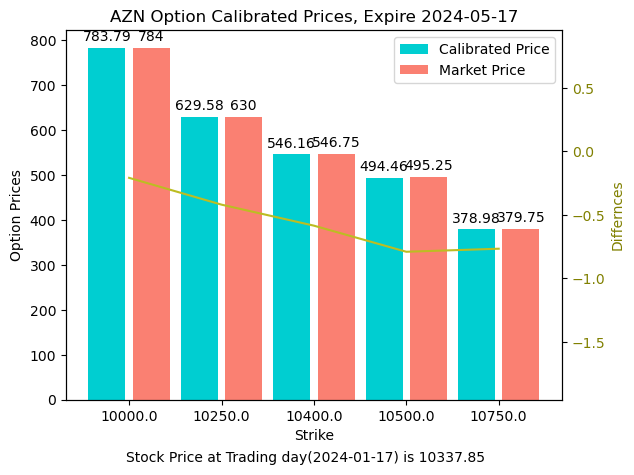

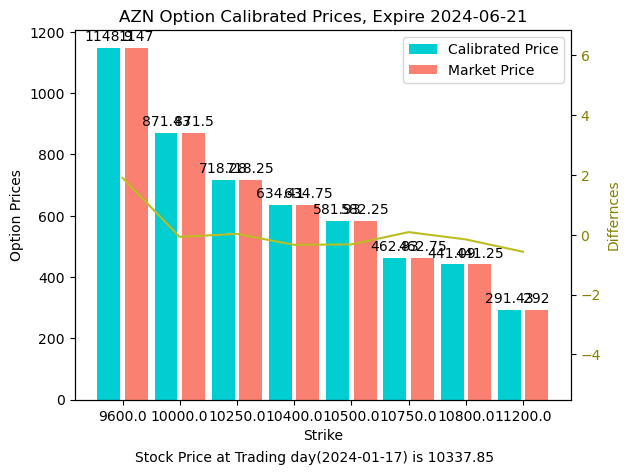

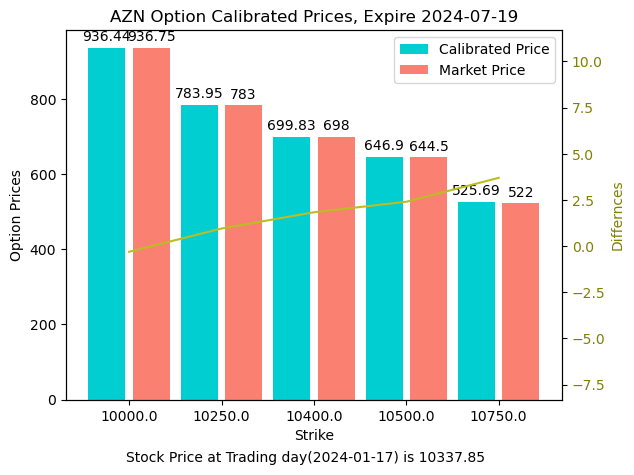

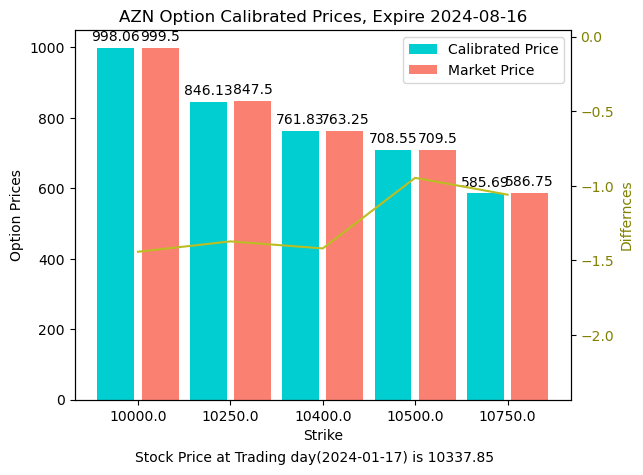

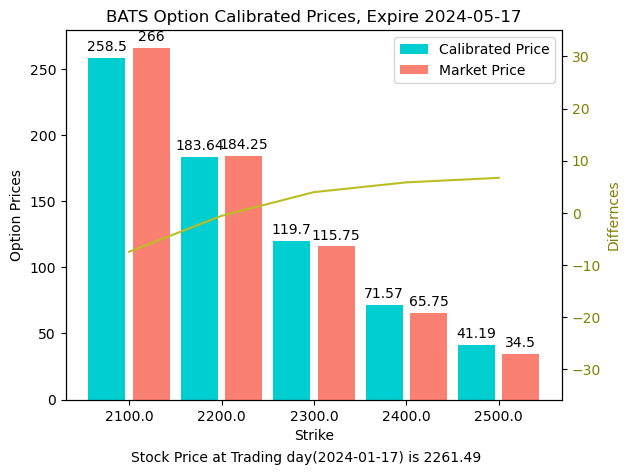

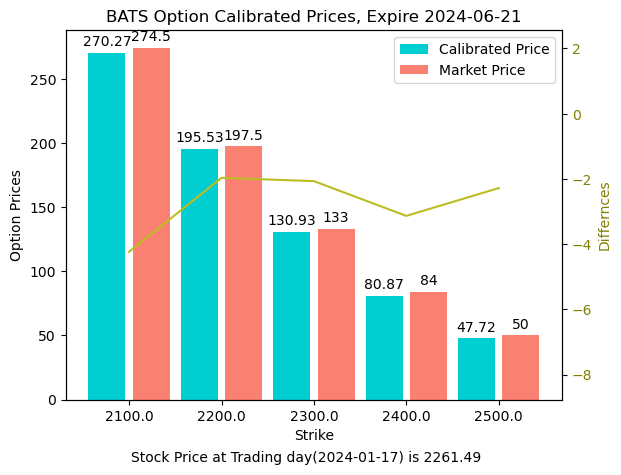

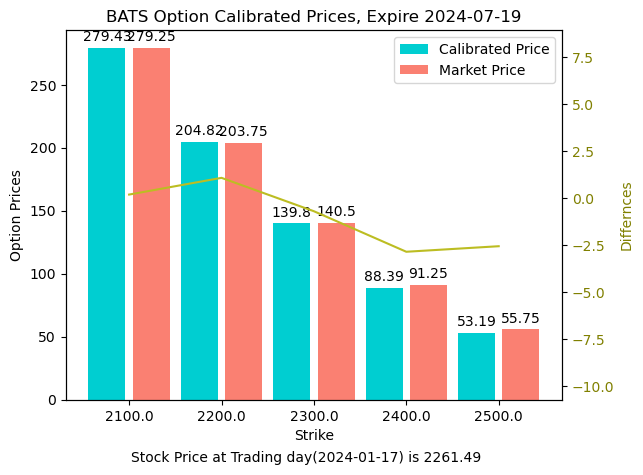

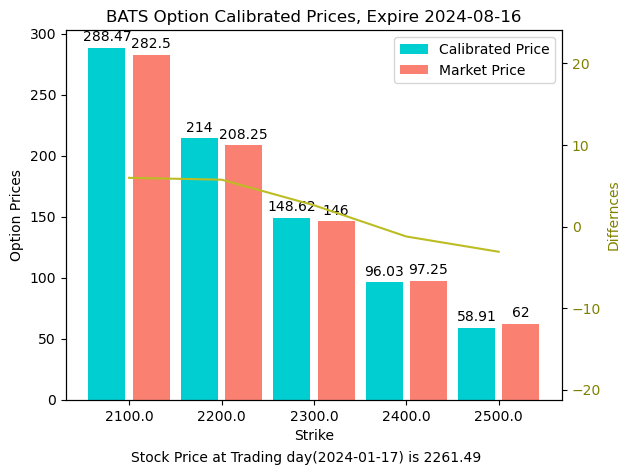

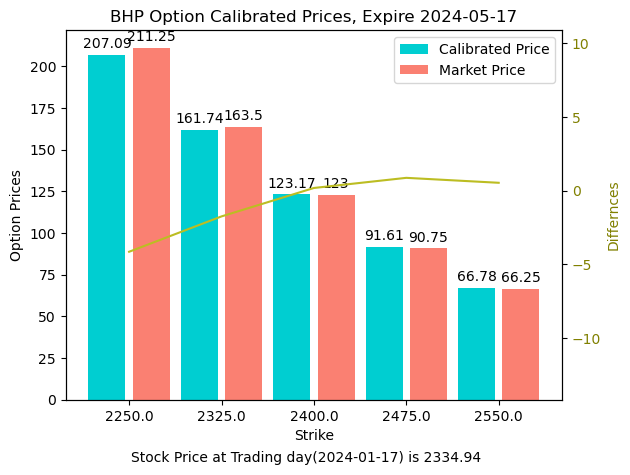

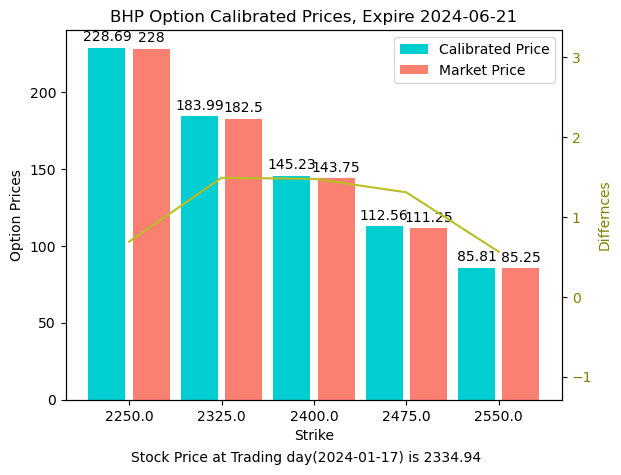

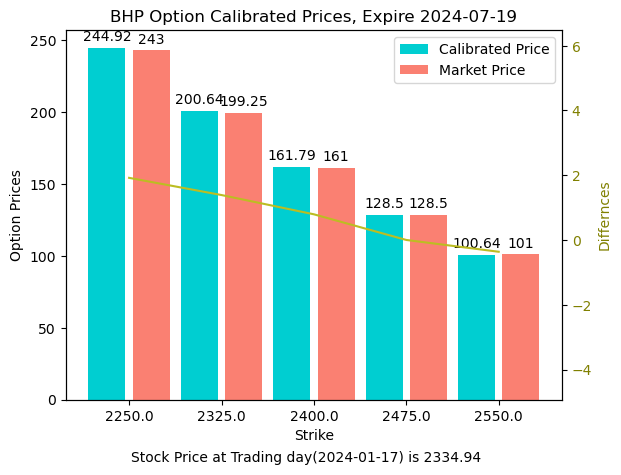

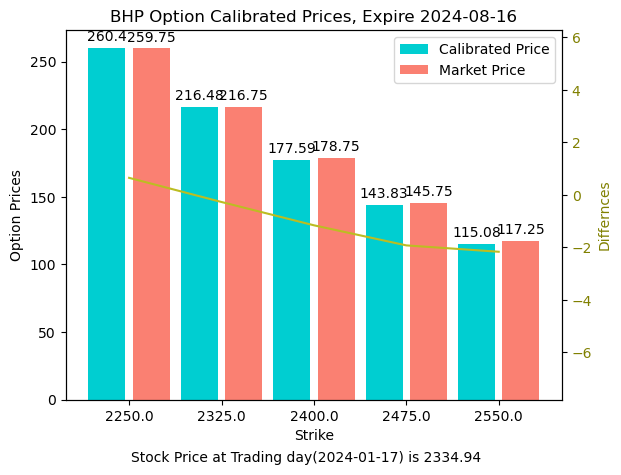

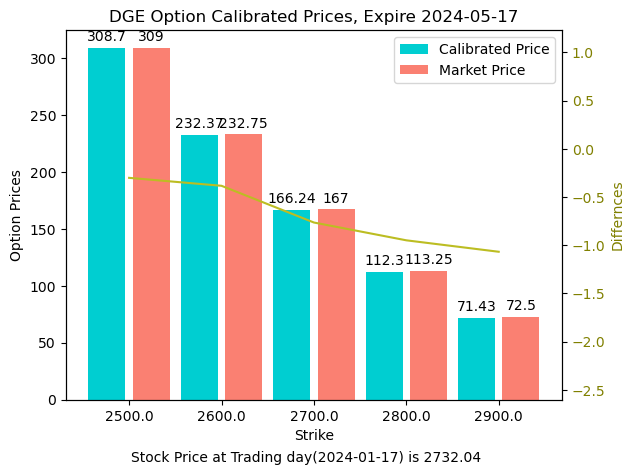

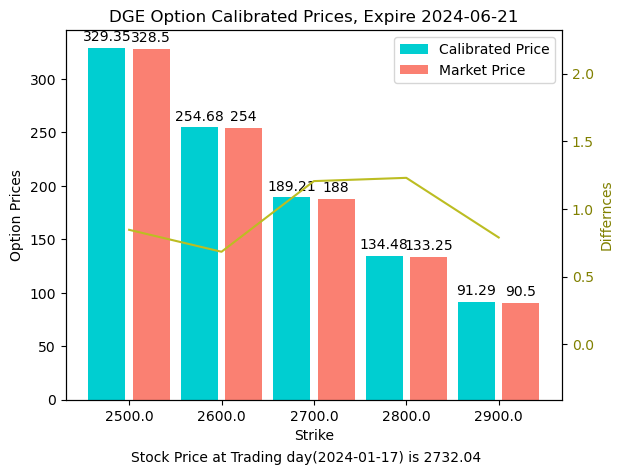

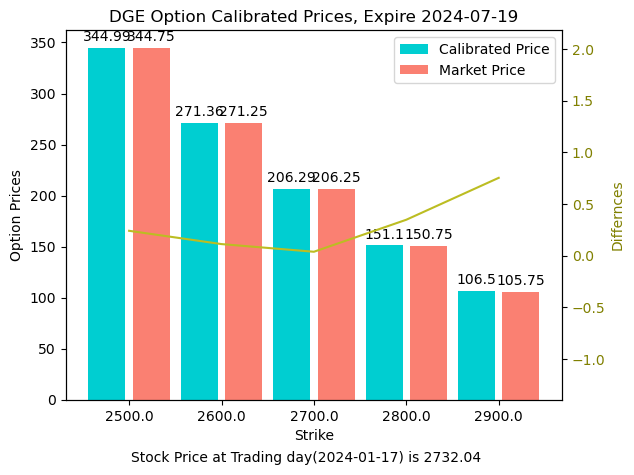

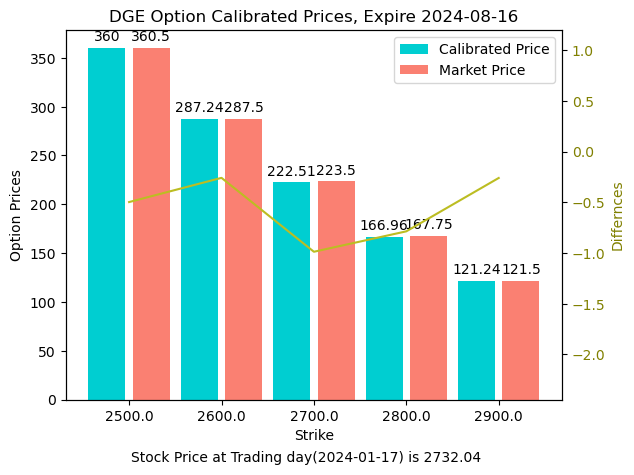

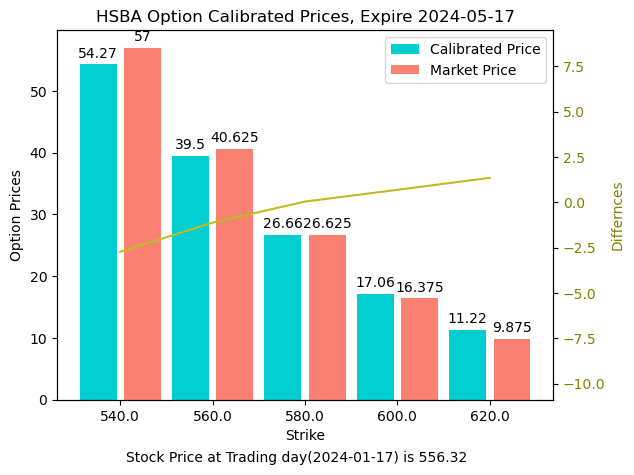

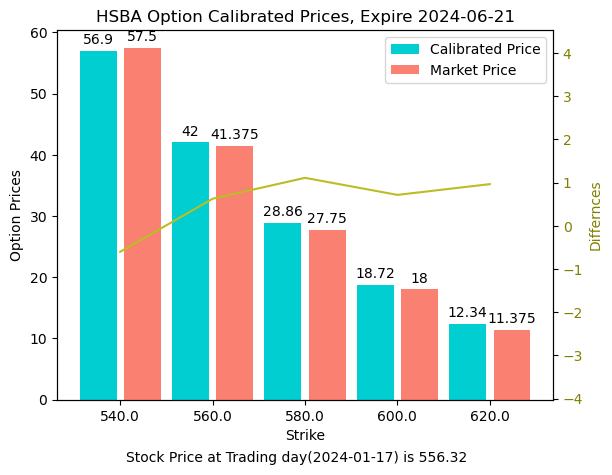

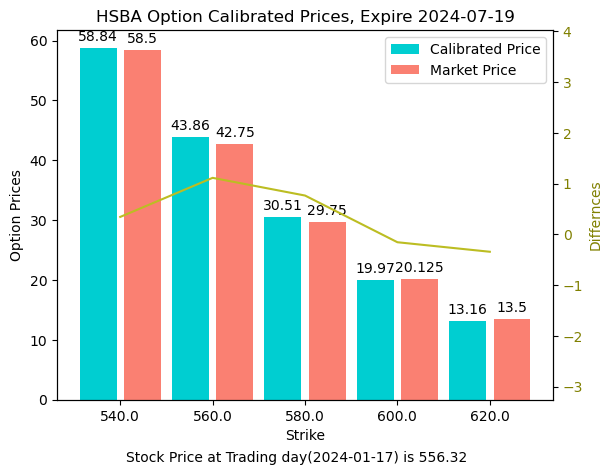

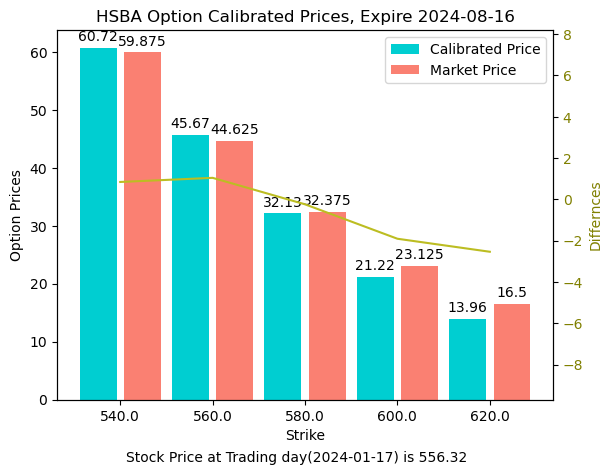

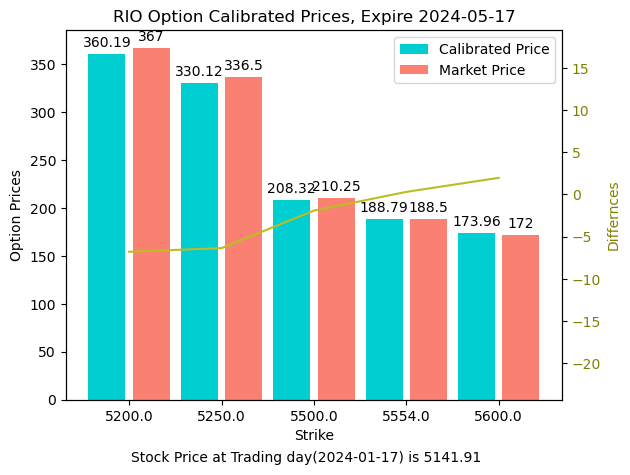

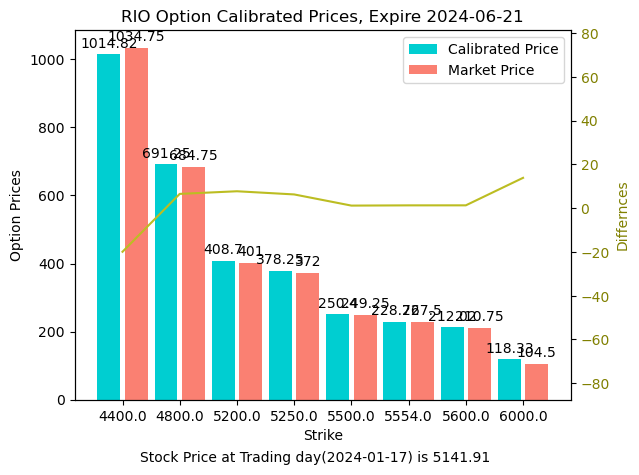

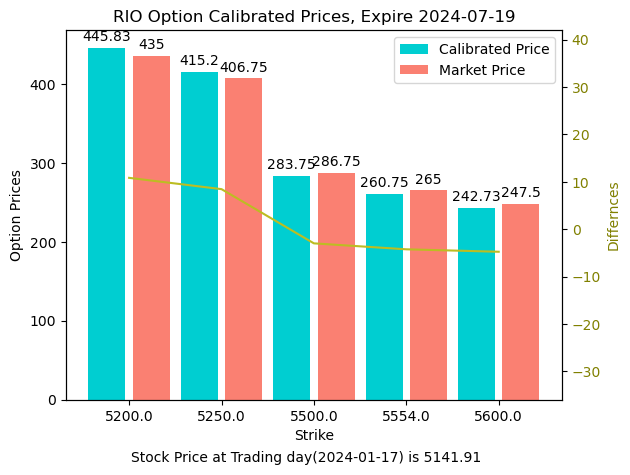

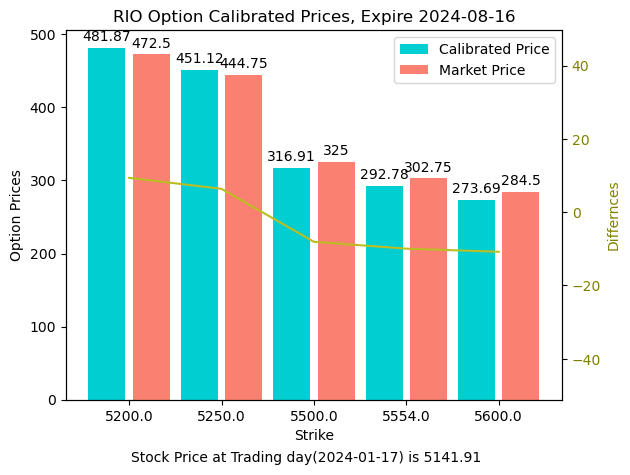

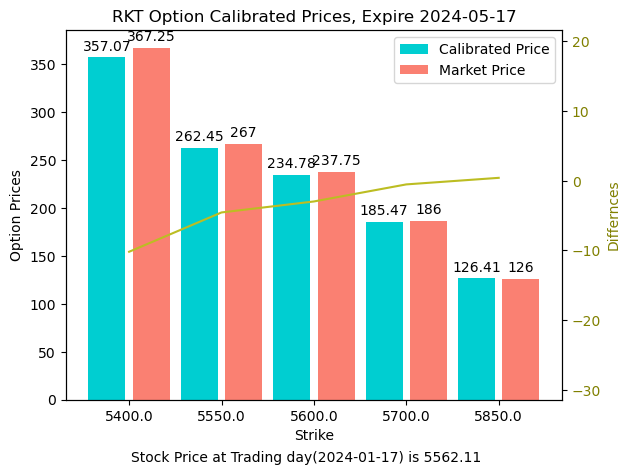

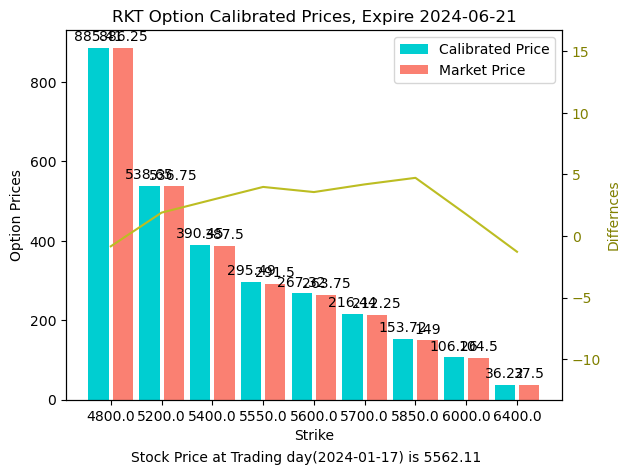

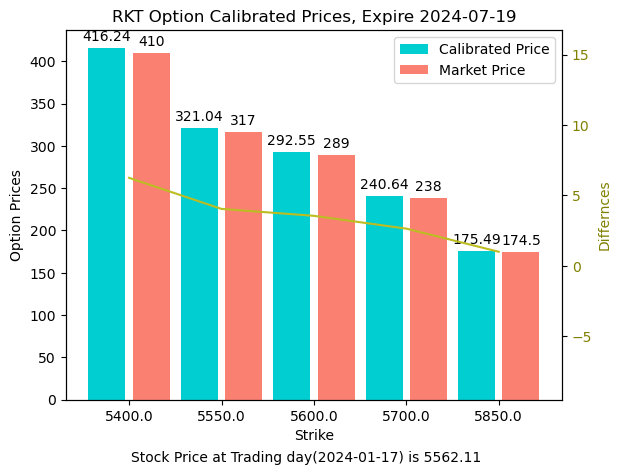

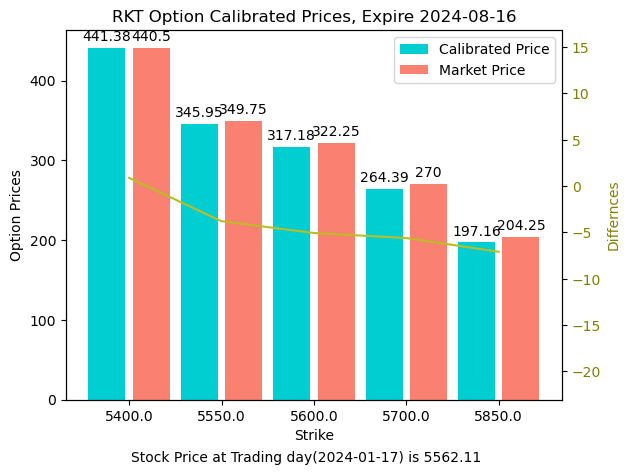

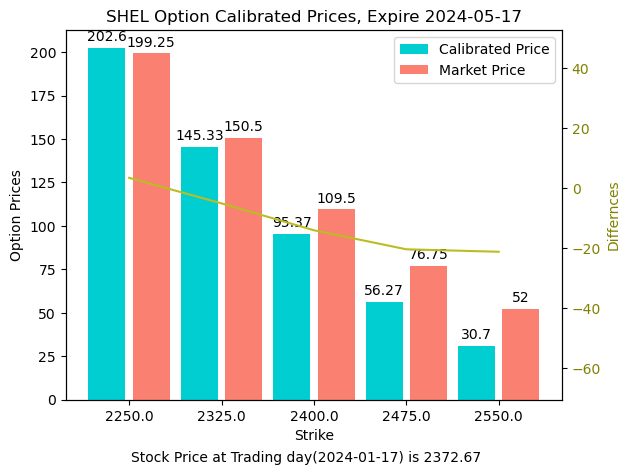

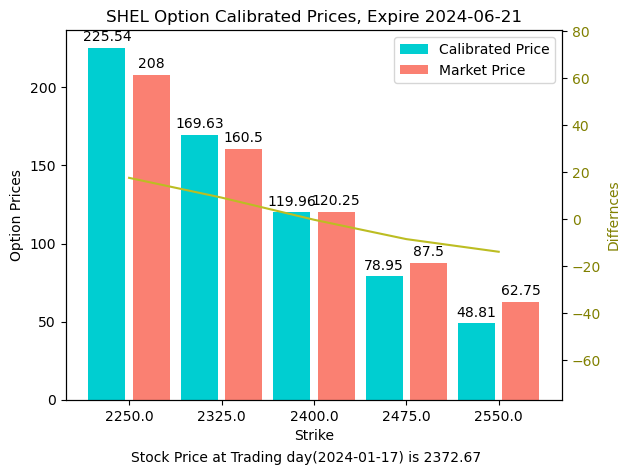

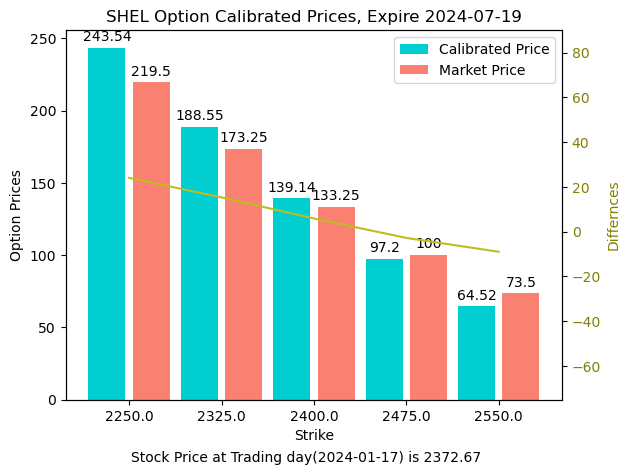

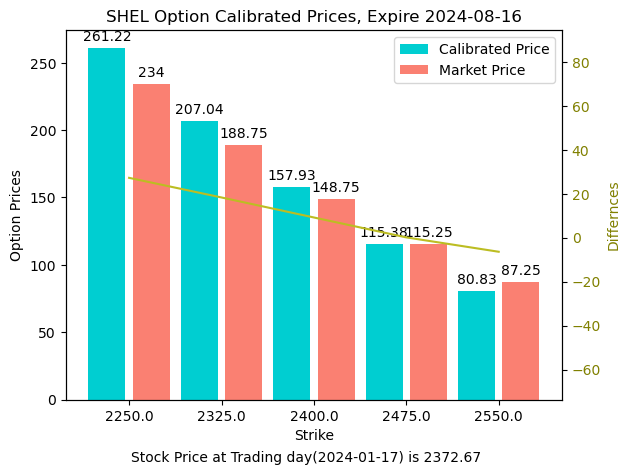

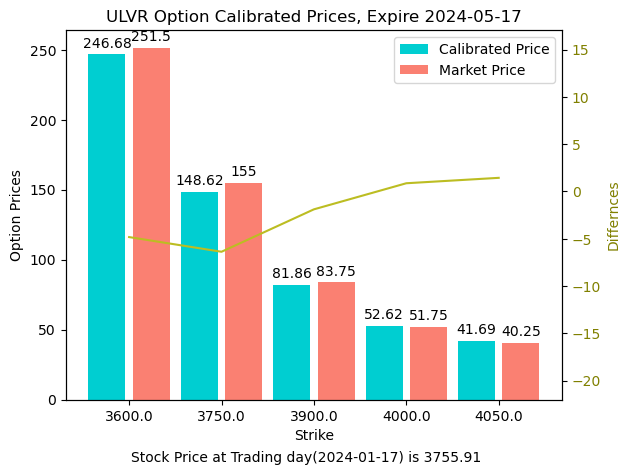

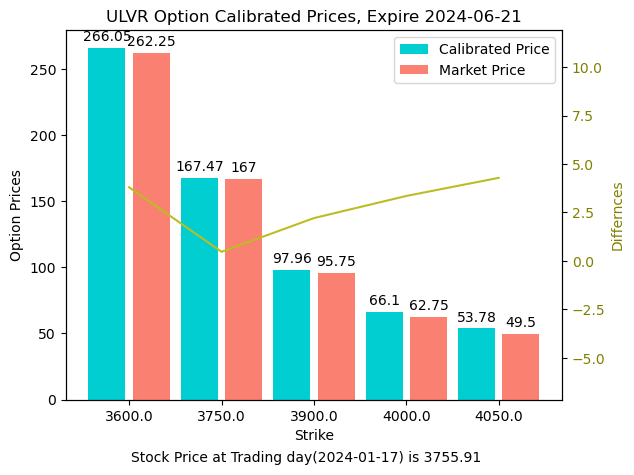

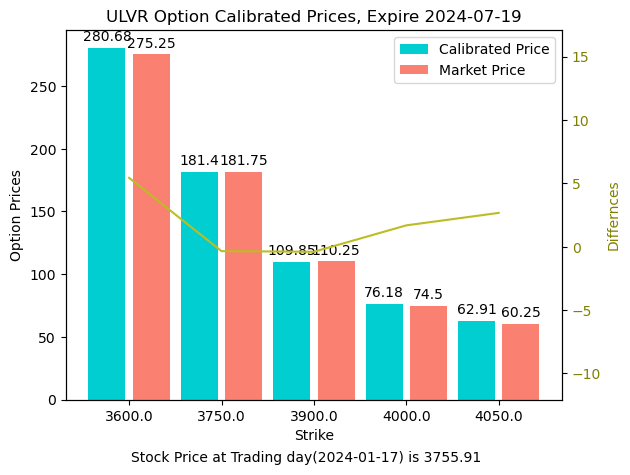

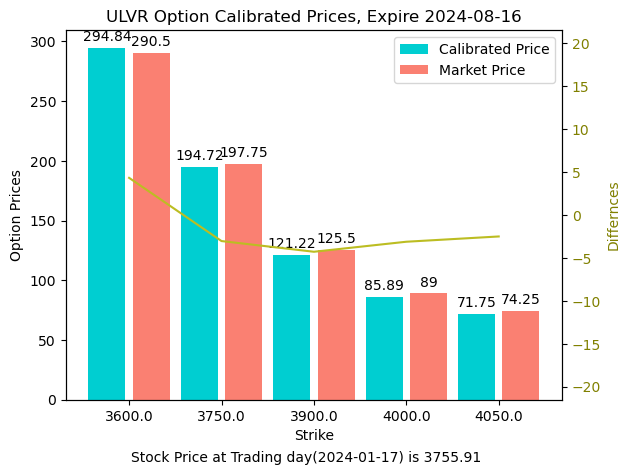

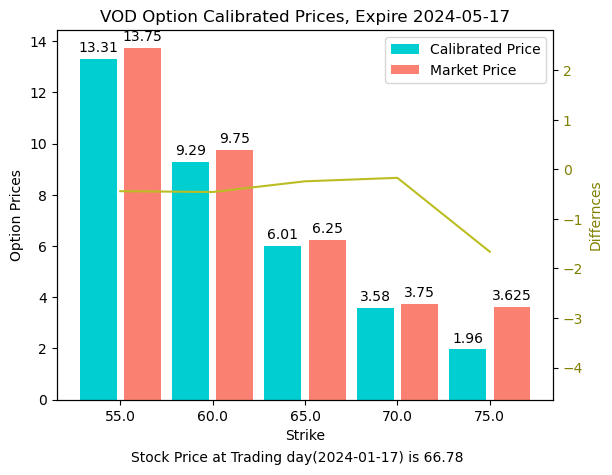

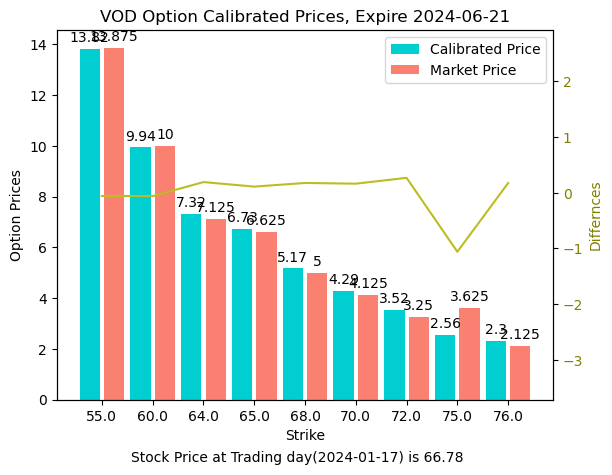

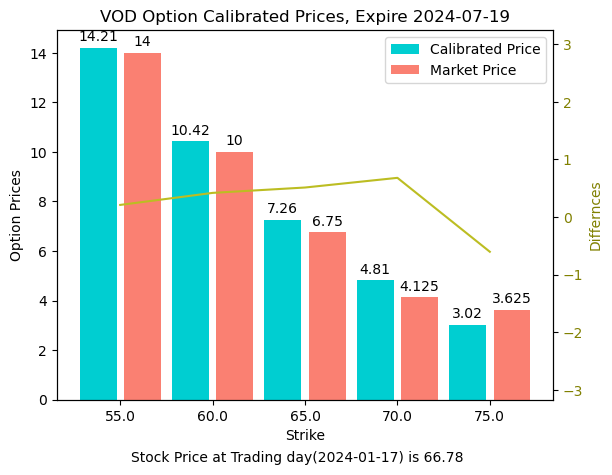

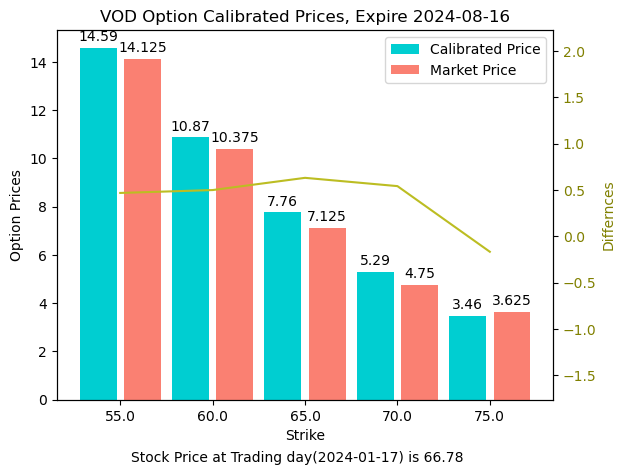

In [210]:
width = 0.4
for j in range(len(options)):
    cur = optionTables[j]
    s0 = acquire_stock_price(j,0)
    
    for i in cur.index.get_level_values(0).unique():
        fig, ax = plt.subplots()
        fig.text(0.5, -0.02, 'Stock Price at Trading day(2024-01-17) is ' + '{:.2f}'.format(s0),
         horizontalalignment="center")

        xs = np.linspace(1, cur.loc[i].shape[0], cur.loc[i].shape[0])
        rects1 = ax.bar(xs - 0.6 * width, cur.loc[i]['model_price'].round(decimals = 2), width, label='Calibrated Price', color = 'darkturquoise')
        ax.bar_label(rects1, padding=3)
        rects2 = ax.bar(xs + 0.6 * width, cur.loc[i]['Mid'], width, label='Market Price', color = 'salmon')
        ax.bar_label(rects2, padding=3)
        ax2 = ax.twinx()  
        ax2.set_ylabel('Differnces', color='olive')
        diff = cur.loc[i]['model_price'] - cur.loc[i]['Mid']
        ax2.plot(xs, diff, color='tab:olive')
        ax2.tick_params(axis='y', labelcolor='olive')
        ax2.set_ylim(3 * min(diff) - 2 * max(diff), 3 * max(diff) - 2 * min(diff))

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Option Prices')
        ax.set_title(options[j] + ' Option Calibrated Prices, Expire ' + str(i)[:10])
        ax.set_xlabel('Strike')
        ax.set_xticks(xs, cur.loc[i].index)
        ax.legend(loc='upper right')
        
        plt.show()


In [13]:
azn_raw_data = pd.read_csv('AZN Calibration Sheet.csv', header = 4)

In [16]:
azn_raw_data.head(10)

,Ticker,Expiry,Trading date,Bid,Ask,Mid,Strike
0,AZA 5/17/24 C10000,17-May-24,17-Jan-24,753.0,815.0,784.00,10000.0
1,AZA 5/17/24 C10250,17-May-24,17-Jan-24,601.5,658.5,630.00,10250.0
2,AZA 5/17/24 C10400,17-May-24,17-Jan-24,519.5,574.0,546.75,10400.0
3,AZA 5/17/24 C10500,17-May-24,17-Jan-24,468.5,522.0,495.25,10500.0
4,AZA 5/17/24 C10750,17-May-24,17-Jan-24,354.5,405.0,379.75,10750.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,AZA 6/21/24 C9600,21-Jun-24,17-Jan-24,1118.5,1175.5,1147.00,9600.0
7,AZA 6/21/24 C10000,21-Jun-24,17-Jan-24,845.5,897.5,871.50,10000.0
8,AZA 6/21/24 C10000,21-Jun-24,17-Jan-24,843.0,900.5,871.75,10000.0
9,AZA 6/21/24 C10250,21-Jun-24,17-Jan-24,691.5,745.0,718.25,10250.0
